In [125]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Pre-processing

In [126]:
bmi_df = pd.read_csv('./data/bodyfat.csv')
bmi_df.head()

,BodyFat,Original,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,Y,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,Y,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,Y,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,Y,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,Y,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [127]:
# drop kolom yang tidak diperlukan 
bmi_df.drop(columns=['Original', 'Neck', 'Forearm', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'], inplace=True)
bmi_df.head()

,BodyFat,Sex,Age,Weight,Height
0,12.3,M,23,69.97,1.72
1,6.1,M,22,78.59,1.84
2,25.3,M,22,69.85,1.68
3,10.4,M,26,83.80,1.84
4,28.7,M,24,83.58,1.81


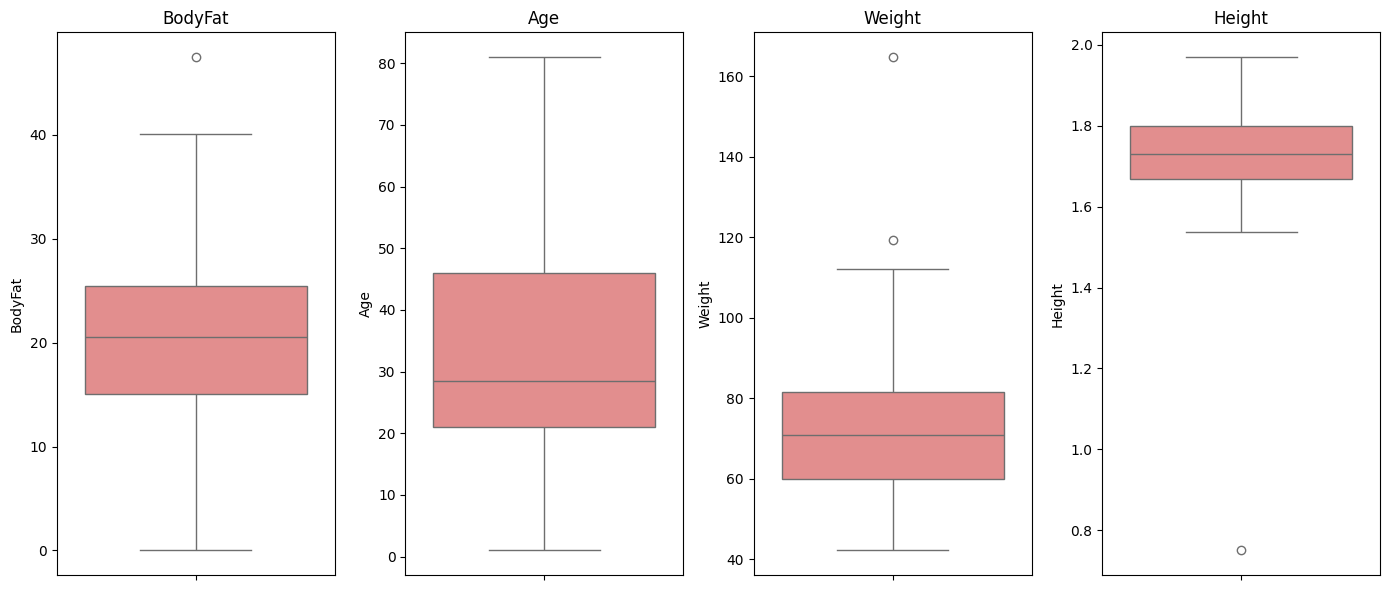

In [128]:
# visualisasi persebaran data menggunakan boxplot untuk mengidentifikasi outlier
numeric_columns = ['BodyFat', 'Age', 'Weight', 'Height']
n = len(numeric_columns)

plt.figure(figsize=(14, 6))

for i, column in enumerate(numeric_columns): 
    plt.subplot(1, n, i+1)
    sns.boxplot(y=bmi_df[column], color='lightcoral')
    plt.title(column)

plt.tight_layout()
plt.show()

Analisis grafik persebaran data dan anomali dalam dataset: 

1. BodyFat memiliki median sekitar 21% pada rentang antar-kuartil (Q1 ke Q3) sekitar 15-26%. Selain itu juga terdapat satu outlier yang cukup tinggi di atas 40% dan satu yang sangat rendah mendekati 0%. 
2. Age memiliki distribusi yang cukup tersebar, mediannya berada di sekitar 28-30 tahun dengan nilai ekstrem yang > 75 tahun dan < 5 tahun. 
3. Weight memiliki median di sekitar 70 kg dengan beberapa outlier yang berada di > 110 kg dan bahkan mendekati 165 kg.
4. Height memiliki median di sekitar 1.74 m debgan besar data terdistribusi normal di kisaran 1.6-1.8 m. Terdapat juga satu outlier rendah di bawah 0.8 m yang sangat tidak masuk akal.

Kesimpulan umum: 
- Terdapat beberapa outlier yang mencolok di bodyfat, height, dan weight
- Terdapat juga nilai ekstrem yang tidak masuk akal (dengan mempertimbangkan aspek fisiologis) seperti bodyfat mendekati 0%. Sementara itu juga terdapat tinggi badan yang terlalu rendah yang kemungkinan akan memengaruhi fuzzy rules-nya.

BodyFat: Dihapus 1 data outlier
Age: Dihapus 0 data outlier
Weight: Dihapus 2 data outlier
Height: Dihapus 1 data outlier


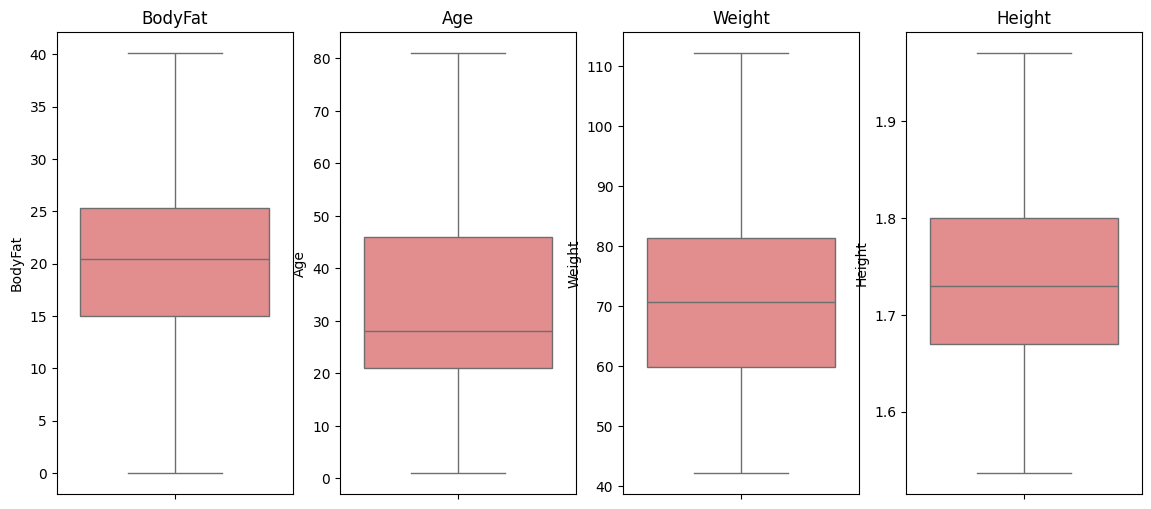

In [129]:
# filter dan menghapus data dari outlier dengan metode IQR (Interquartile Range)
for column in numeric_columns:
    Q1 = bmi_df[column].quantile(0.25)
    Q3 = bmi_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before = bmi_df.shape[0]
    bmi_df = bmi_df[(bmi_df[column] >= lower_bound) & (bmi_df[column] <= upper_bound)]
    after = bmi_df.shape[0]
    print(f"{column}: Dihapus {before - after} data outlier")

# visualisasi persebaran data setelah menghapus outlier
plt.figure(figsize=(14, 6))
for i, column in enumerate(numeric_columns): 
    plt.subplot(1, n, i+1)
    sns.boxplot(y=bmi_df[column], color='lightcoral')
    plt.title(column)

Langkah selanjutnya adalah memastikan bahwa data yang digunakan juga amsuk akal secara fisiologis. Nilai BodyFat mendekati 0% sangat tidak realistis bagi manusia. Acuan yang akan digunakan adalah Body Fat Minimum (American Council on Exercise)

- Pria: BodyFat < 4% (dihapus)
- Wanita: BodyFat < 10% (dihapus)

In [130]:
# jumlah sebelum pembersihan 
before = bmi_df.shape[0]

# filter berdasarkan gender 
bmi_df = bmi_df[~((bmi_df['Sex'] == 'M') & (bmi_df['BodyFat'] < 4))]
bmi_df = bmi_df[~((bmi_df['Sex'] == 'F') & (bmi_df['BodyFat'] < 10))]

# jumlah setelah pembersihan 
after = bmi_df.shape[0]
print(f"Jumlah data sebelum pembersihan: {before-after}")

Jumlah data sebelum pembersihan: 8


In [131]:
# hapus usia yang terlalu muda atau terlalu tua 
bmi_df = bmi_df[~((bmi_df['Age'] < 10) | (bmi_df['Age'] > 65))]

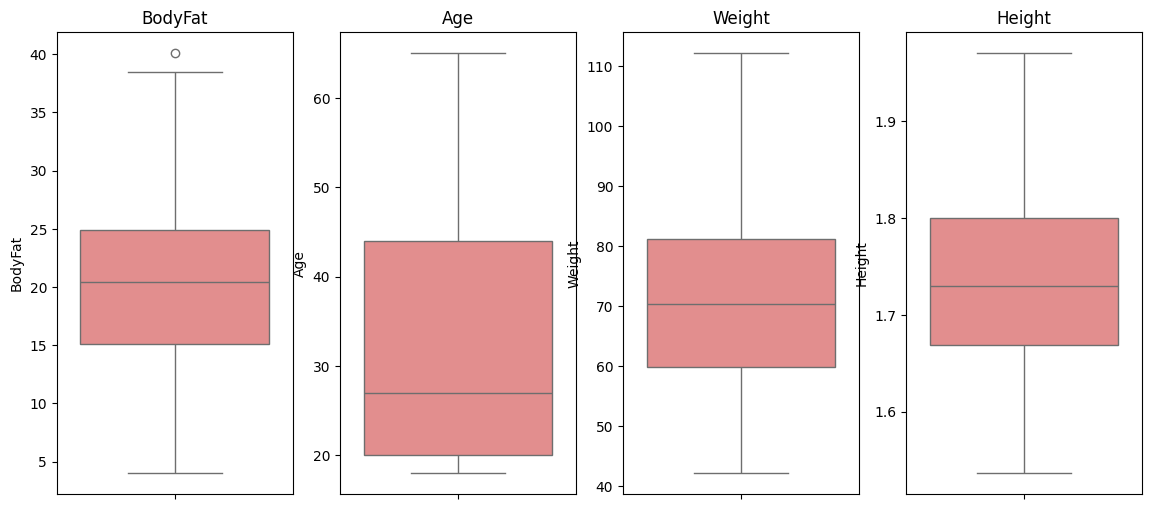

In [132]:
# visualisasi persebaran data setelah menghapus data yang tidak valid
plt.figure(figsize=(14, 6))
for i, column in enumerate(numeric_columns): 
    plt.subplot(1, n, i+1)
    sns.boxplot(y=bmi_df[column], color='lightcoral')
    plt.title(column)

In [133]:
# hitung BMI untuk setiap entri 
bmi_df['BMI'] = bmi_df['Weight'] / (bmi_df['Height'] ** 2)

In [134]:
# menambahkan kolom kategori BMI 
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal weight'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'
    
bmi_df['BMI_Category'] = bmi_df['BMI'].apply(categorize_bmi)

In [135]:
def categorize_body_fat_gendered(row):
    fat = row['BodyFat']
    gender = row['Sex']
    if gender == 'M': # ACE guidelines for Men
        if fat < 6: return 'essential_too_low' # Essential fat is 2-5%, <2% is risky
        elif fat < 14: return 'athletes'
        elif fat < 18: return 'fitness'
        elif fat < 25: return 'average'
        else: return 'obese'
    else: # ACE guidelines for Women
        if fat < 14: return 'essential_too_low' # Essential fat is 10-13%, <10% is risky
        elif fat < 21: return 'athletes'
        elif fat < 25: return 'fitness'
        elif fat < 32: return 'average'
        else: return 'obese'
        
bmi_df['Body_Fat_Category_Gendered'] = bmi_df.apply(categorize_body_fat_gendered, axis=1)

In [136]:
def synthetic_calories(row):
    gender = row['Sex'].lower()
    age = row['Age']
    bmi = row['BMI']
    bodyfat = row['BodyFat']

    if gender == 'm':
        base_cal = 2500 # Approx. for 19-30 sedentary/low active
    else:
        base_cal = 2000 # Approx. for 19-30 sedentary/low active

    if age < 18: # Should not happen with current age filter
        base_cal -= 300
    elif age > 50:
        base_cal -= 200

    if bmi < 18.5 or bodyfat < (10 if gender == 'f' else 4) : # Adjusted bodyfat condition
        base_cal += 300
    elif bmi >= 30 or bodyfat >= (32 if gender == 'f' else 25): # Adjusted bodyfat condition
        base_cal -= 400
    elif bmi >= 24.9 or bodyfat >= (25 if gender == 'f' else 18): # Adjusted BMI and bodyfat
        base_cal -= 200
    
    # Ensure calories don't go unrealistically low
    min_cal = 1200 if gender == 'f' else 1500
    base_cal = max(base_cal, min_cal)

    return np.random.randint(base_cal - 100, base_cal + 100)

In [137]:
# Cell 16: NEW Synthetic Protein Target Generation
def get_protein_rda_g(age, sex):
    sex = sex.lower()
    if 10 <= age <= 13: return 34
    elif 14 <= age <= 18: return 46 if sex == 'f' else 52
    elif 19 <= age <= 65: return 46 if sex == 'f' else 56 # Covers up to 65 from our filter
    else: return 46 if sex == 'f' else 56 # Default for >65, though filtered out

In [138]:
def get_sedentary_calories(age, sex): # Approximate from Dietary Guidelines Table A2-2
    sex = sex.lower()
    if 10 <= age <= 13: return 1600 if sex == 'f' else 1800 # Approx average for sedentary
    elif 14 <= age <= 18: return 1800 if sex == 'f' else 2200
    elif 19 <= age <= 30: return 2000 if sex == 'f' else 2400 # Using lower end of range
    elif 31 <= age <= 50: return 1800 if sex == 'f' else 2200
    elif 51 <= age <= 65: return 1600 if sex == 'f' else 2000
    else: return 1600 if sex == 'f' else 2000

In [139]:
def synthetic_protein_target(row):
    age = row['Age']
    sex = row['Sex']
    weight_kg = row['Weight']
    bmi = row['BMI']
    calories = row['Calories'] # Use the already synthesized calories

    protein_rda_base = get_protein_rda_g(age, sex)
    sedentary_cal = get_sedentary_calories(age, sex)

    target_protein = protein_rda_base

    # Adjust based on activity (inferred from calories vs sedentary) and BMI goals
    activity_factor = 1.0
    if calories > sedentary_cal * 1.25: # Significantly more active
        activity_factor = 1.5
    elif calories > sedentary_cal * 1.1: # Moderately more active
        activity_factor = 1.2

    if bmi < 18.5: # Underweight
        target_protein = max(protein_rda_base, activity_factor * 1.2 * weight_kg) # Higher g/kg for gain
        target_protein *= 1.1 # General 10% boost for underweight aiming for gain
    elif bmi >= 29.9: # Obese (using 29.9 as threshold to match BMI category)
        target_protein = max(protein_rda_base, activity_factor * 1.0 * weight_kg) # RDA or active RDA is minimum
        target_protein *= 1.25 # 25% boost for satiety/muscle preservation during likely deficit
    elif bmi >= 24.9: # Overweight
        target_protein = max(protein_rda_base, activity_factor * 1.0 * weight_kg)
        target_protein *= 1.15 # 15% boost
    else: # Normal weight
        target_protein = max(protein_rda_base, activity_factor * 1.0 * weight_kg) # RDA or active RDA

    # Add some noise
    target_protein += np.random.uniform(-10, 10)
    
    # Ensure protein isn't excessively low or high in absolute grams
    target_protein = np.clip(target_protein, 30, 250) 

    return round(target_protein, 1)

In [140]:
bmi_df['Calories'] = bmi_df.apply(synthetic_calories, axis=1)
bmi_df['Protein'] = bmi_df.apply(synthetic_protein_target, axis=1)


--- New Synthetic Data Distributions ---
          Calories     Protein
count   405.000000  405.000000
mean   2132.985185   79.489383
std     239.333470   20.535664
min    1511.000000   43.200000
25%    1960.000000   63.300000
50%    2097.000000   76.700000
75%    2319.000000   93.900000
max    2598.000000  149.700000


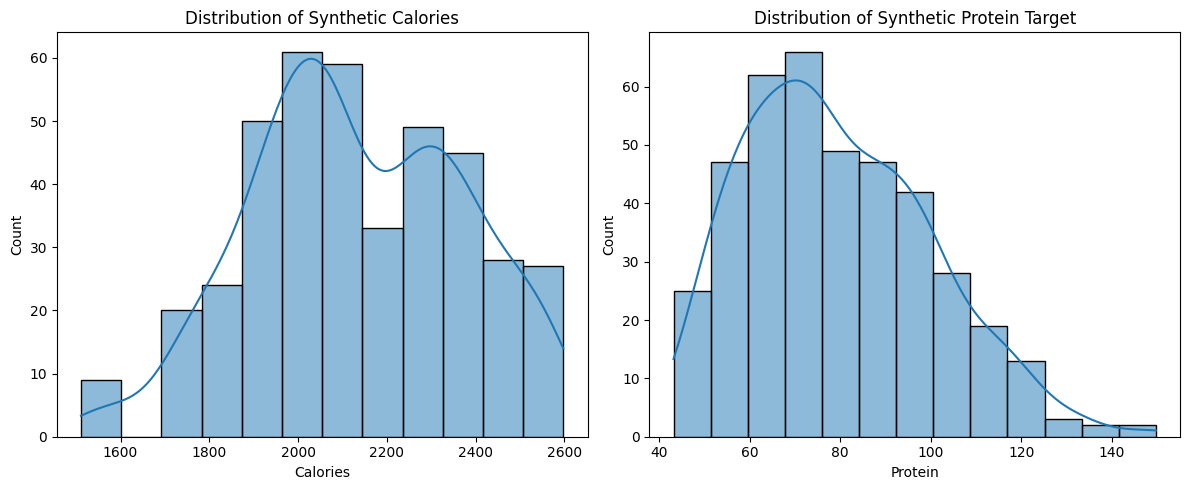

In [141]:
print("\n--- New Synthetic Data Distributions ---")
print(bmi_df[['Calories', 'Protein']].describe())
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(bmi_df['Calories'], kde=True)
plt.title('Distribution of Synthetic Calories')
plt.subplot(1, 2, 2)
sns.histplot(bmi_df['Protein'], kde=True)
plt.title('Distribution of Synthetic Protein Target')
plt.tight_layout()
plt.show()

In [142]:
bmi_df.head()

,BodyFat,Sex,Age,Weight,Height,BMI,BMI_Category,Body_Fat_Category_Gendered,Calories,Protein
0,12.3,M,23,69.97,1.72,23.651298,Normal weight,athletes,2527,72.5
1,6.1,M,22,78.59,1.84,23.213020,Normal weight,athletes,2504,76.7
2,25.3,M,22,69.85,1.68,24.748441,Normal weight,obese,2042,62.6
3,10.4,M,26,83.80,1.84,24.751890,Normal weight,athletes,2441,91.5
4,28.7,M,24,83.58,1.81,25.512042,Overweight,obese,2165,100.7


# 1. Linguistic variables and memberships

In [143]:
def bmi_underweight(bmi):
    if bmi <= 0:
        return 1
    elif 0 < bmi < 17:
        return 1
    elif 17 <= bmi < 18.5:
        return (18.5 - bmi) / (18.5 - 17)
    else:
        return 0

def bmi_normal(bmi):
    if bmi < 17:
        return 0
    elif 17 <= bmi < 18.5:
        return (bmi - 17) / (18.5 - 17)
    elif 18.5 <= bmi < 23:
        return 1
    elif 23 <= bmi < 24.9:
        return (24.9 - bmi) / (24.9 - 23)
    else:
        return 0

def bmi_overweight(bmi):
    if bmi < 23:
        return 0
    elif 23 <= bmi < 25:
        return (bmi - 23) / (25 - 23)
    elif 25 <= bmi < 28:
        return 1
    elif 28 <= bmi < 29.9:
        return (29.9 - bmi) / (29.9 - 28)
    else:
        return 0

def bmi_obese(bmi):
    if bmi < 28:
        return 0
    elif 28 <= bmi < 30:
        return (bmi - 28) / (30 - 28)
    elif 30 <= bmi <= 40:
        return 1
    else:
        return 0

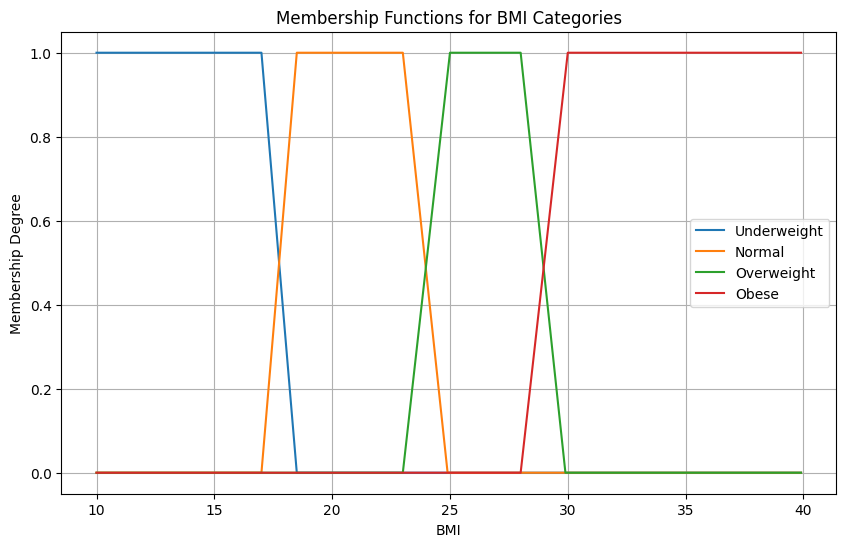

In [144]:
x_bmi = np.arange(10, 40, 0.1)

underweight = [bmi_underweight(x) for x in x_bmi]
normal = [bmi_normal(x) for x in x_bmi]
overweight = [bmi_overweight(x) for x in x_bmi]
obese = [bmi_obese(x) for x in x_bmi]

# Plot the membership functions
plt.figure(figsize=(10, 6))
plt.plot(x_bmi, underweight, label='Underweight')
plt.plot(x_bmi, normal, label='Normal')
plt.plot(x_bmi, overweight, label='Overweight')
plt.plot(x_bmi, obese, label='Obese')

plt.title('Membership Functions for BMI Categories')
plt.xlabel('BMI')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

In [145]:
def bfw_essential(bodyfat):
    if bodyfat <= 10:
        return 1
    elif 10 < bodyfat <= 14:
        return (14 - bodyfat) / (14 - 10)
    else:
        return 0

def bfw_athletes(bodyfat):
    if 13 < bodyfat <= 17:
        return (bodyfat - 13) / (17 - 13)
    elif 17 <= bodyfat <= 20:
        return 1
    elif 20 < bodyfat <= 22:
        return (22 - bodyfat) / (22 - 20)
    else:
        return 0

def bfw_fitness(bodyfat):
    if 21 <= bodyfat <= 22:
        return (bodyfat - 21) / (22 - 21)
    elif 22 <= bodyfat <= 24:
        return 1
    elif 24 < bodyfat <= 25:
        return (25 - bodyfat) / (25 - 24)
    else:
        return 0

def bfw_average(bodyfat):
    if 24 < bodyfat <= 27:
        return (bodyfat - 24) / (27 - 24)
    elif 27 <= bodyfat <= 31:
        return 1
    elif 31 < bodyfat <= 32:
        return (32 - bodyfat) / (32 - 31)
    else:
        return 0

def bfw_obese(bodyfat):
    if bodyfat >= 32:
        return 1
    elif 31 < bodyfat <= 32:
        return (bodyfat - 31) / (32 - 31)
    else:
        return 0

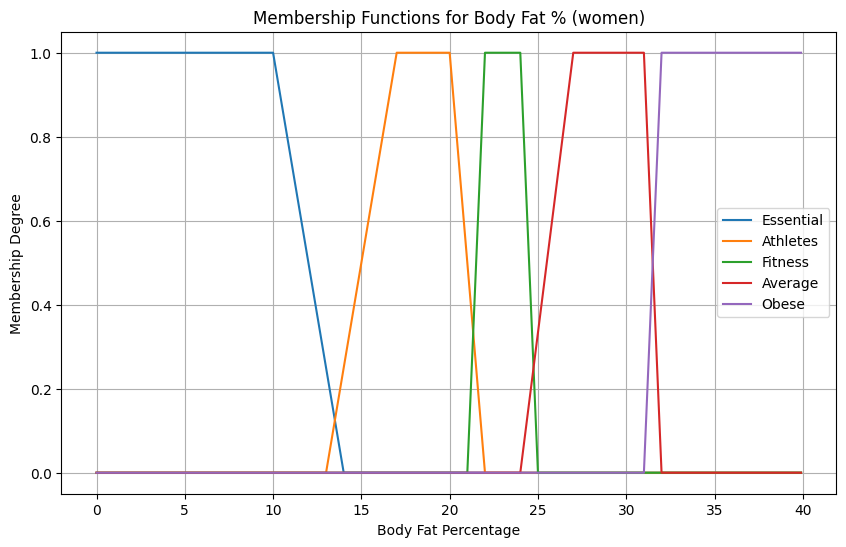

In [146]:
x_bf = np.arange(0, 40, 0.1) # range of discourse 

essential = [bfw_essential(x) for x in x_bf]
athletes = [bfw_athletes(x) for x in x_bf]
fitness = [bfw_fitness(x) for x in x_bf]
average = [bfw_average(x) for x in x_bf]
obese = [bfw_obese(x) for x in x_bf]

plt.figure(figsize=(10, 6))
plt.plot(x_bf, essential, label='Essential')
plt.plot(x_bf, athletes, label='Athletes')
plt.plot(x_bf, fitness, label='Fitness')
plt.plot(x_bf, average, label='Average')
plt.plot(x_bf, obese, label='Obese')

plt.title('Membership Functions for Body Fat % (women)')
plt.xlabel('Body Fat Percentage')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
def bfm_essential(bodyfat):
    if bodyfat <= 2:
        return 1
    elif 2 < bodyfat <= 6:
        return (6 - bodyfat) / (6 - 2)
    else:
        return 0

def bfm_athletes(bodyfat):
    if 5 < bodyfat <= 9:
        return (bodyfat - 5) / (9 - 5)
    elif 9 <= bodyfat <= 13:
        return 1
    elif 13 < bodyfat <= 15:
        return (15 - bodyfat) / (15 - 13)
    else:
        return 0

def bfm_fitness(bodyfat):
    if 14 <= bodyfat <= 15:
        return (bodyfat - 14) / (15 - 14)
    elif 15 <= bodyfat <= 17:
        return 1
    elif 17 < bodyfat <= 18:
        return (18 - bodyfat) / (18 - 17)
    else:
        return 0

def bfm_average(bodyfat):
    if 17 < bodyfat <= 20:
        return (bodyfat - 17) / (20 - 17)
    elif 20 <= bodyfat <= 24:
        return 1
    elif 24 < bodyfat <= 25:
        return (25 - bodyfat) / (25 - 24)
    else:
        return 0

def bfm_obese(bodyfat):
    if bodyfat >= 25:
        return 1
    elif 24 < bodyfat <= 25:
        return (bodyfat - 24) / (25 - 24)
    else:
        return 0

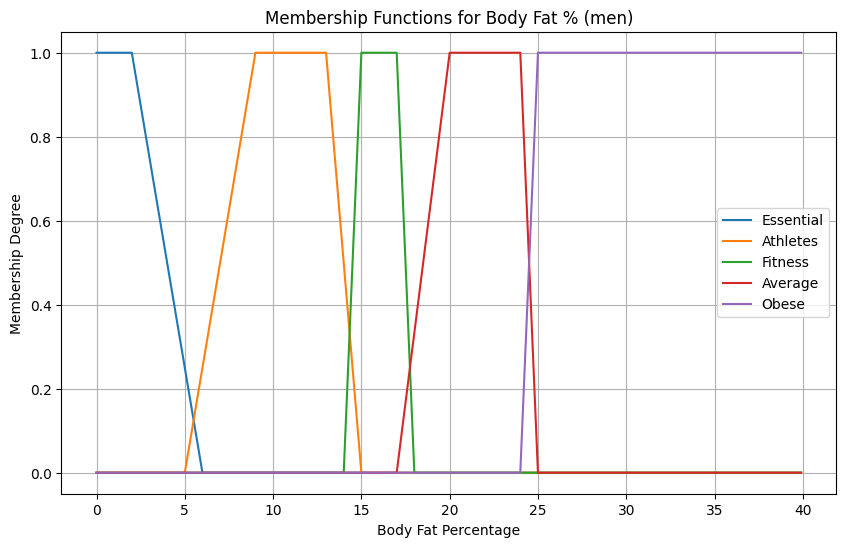

In [148]:
essential = [bfm_essential(x) for x in x_bf]
athletes = [bfm_athletes(x) for x in x_bf]
fitness = [bfm_fitness(x) for x in x_bf]
average = [bfm_average(x) for x in x_bf]
obese = [bfm_obese(x) for x in x_bf]

plt.figure(figsize=(10, 6))
plt.plot(x_bf, essential, label='Essential')
plt.plot(x_bf, athletes, label='Athletes')
plt.plot(x_bf, fitness, label='Fitness')
plt.plot(x_bf, average, label='Average')
plt.plot(x_bf, obese, label='Obese')

plt.title('Membership Functions for Body Fat % (men)')
plt.xlabel('Body Fat Percentage')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()


In [149]:
bmi_test = np.arange(10, 40, 1)

bodyfat_test = {
    "women": np.arange(10, 40, 0.1),
    "men": np.arange(0, 35, 0.1)
}

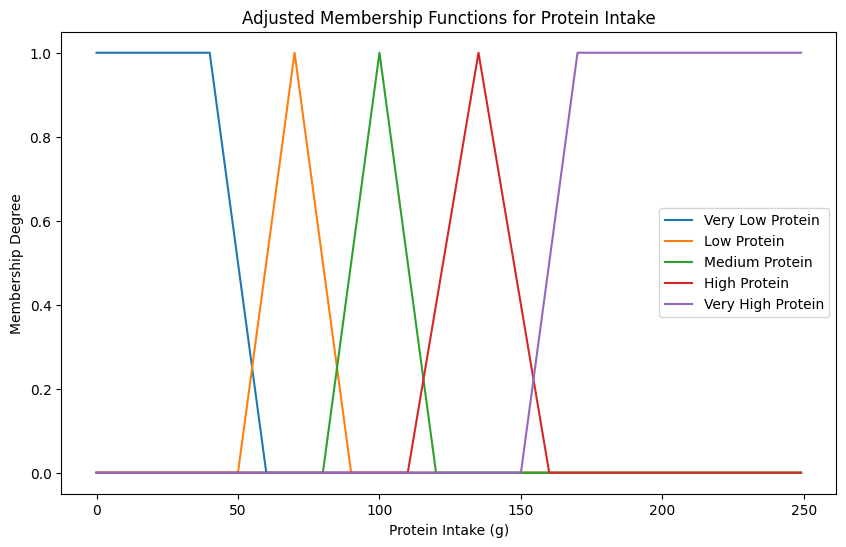

In [150]:
def very_low_protein_mf(protein): # e.g., for significant calorie restriction, less active obese
    # Peak around 40-50g
    if protein <= 40: return 1.0
    elif 40 < protein <= 60: return (60 - protein) / (60 - 40)
    else: return 0.0

def low_protein_mf(protein): # e.g., moderate deficit, or less active normal weight
    # Peak around 65-75g
    if 50 < protein <= 70: return (protein - 50) / (70 - 50)
    elif 70 < protein <= 90: return (90 - protein) / (90 - 70)
    else: return 0.0

def medium_protein_mf(protein): # e.g., maintenance, moderately active
    # Peak around 95-105g
    if 80 < protein <= 100: return (protein - 80) / (100 - 80)
    elif 100 < protein <= 120: return (120 - protein) / (120 - 100)
    else: return 0.0

def high_protein_mf(protein): # e.g., active, muscle gain, or higher need for satiety
    # Peak around 130-140g
    if 110 < protein <= 135: return (protein - 110) / (135 - 110)
    elif 135 < protein <= 160: return (160 - protein) / (160 - 135)
    else: return 0.0

def very_high_protein_mf(protein): # e.g., very active, significant muscle building focus
    # Peak > 160g
    if protein < 150: return 0.0
    elif 150 <= protein < 170: return (protein - 150) / (170 - 150)
    else: return 1.0

# Re-plot Protein MFs
x_protein = np.arange(0, 250, 1) # Adjusted range
very_low_protein = [very_low_protein_mf(x) for x in x_protein]
low_protein = [low_protein_mf(x) for x in x_protein]
medium_protein = [medium_protein_mf(x) for x in x_protein]
high_protein = [high_protein_mf(x) for x in x_protein]
very_high_protein = [very_high_protein_mf(x) for x in x_protein]
plt.figure(figsize=(10, 6))
plt.plot(x_protein, very_low_protein, label='Very Low Protein')
plt.plot(x_protein, low_protein, label='Low Protein')
plt.plot(x_protein, medium_protein, label='Medium Protein')
plt.plot(x_protein, high_protein, label='High Protein')
plt.plot(x_protein, very_high_protein, label='Very High Protein')
plt.title('Adjusted Membership Functions for Protein Intake')
plt.xlabel('Protein Intake (g)')
plt.ylabel('Membership Degree')
plt.legend()

# 2. Fuzzification

In [151]:
bmi_terms = {
    'underweight': bmi_underweight,
    'normal': bmi_normal,
    'overweight': bmi_overweight,
    'obese': bmi_obese
}
bfm_terms = { # Men
    'essential': bfm_essential, 'athletes': bfm_athletes, 'fitness': bfm_fitness,
    'average': bfm_average, 'obese': bfm_obese
}
bfw_terms = { # Women
    'essential': bfw_essential, 'athletes': bfw_athletes, 'fitness': bfw_fitness,
    'average': bfw_average, 'obese': bfw_obese
}
protein_terms = {
    'very_low': very_low_protein_mf, 'low': low_protein_mf, 'medium': medium_protein_mf,
    'high': high_protein_mf, 'very_high': very_high_protein_mf
}

In [152]:
# visualize the fuzzification in tabular form 
def bmi_fuzzification(bmi):
    fuzzified_bmi = fuzzify_bmi(bmi)
    df = pd.DataFrame(fuzzified_bmi, index=[0])
    df.index = [f"{bmi}"]
    return df

def bodyfat_fuzzification(bodyfat, gender): 
    fuzzified_bodyfat = fuzzify_bodyfat(bodyfat, gender)
    df = pd.DataFrame(fuzzified_bodyfat, index=[0])
    df.index = [f"{bodyfat}"]
    return df

def fuzzification_table(bmi, bodyfat, gender):
    bmi_df = bmi_fuzzification(bmi)
    bodyfat_df = bodyfat_fuzzification(bodyfat, gender)
    combined_df = pd.concat([bmi_df, bodyfat_df], axis=1)
    combined_df.columns = pd.MultiIndex.from_product([["Underweight", "Normal", "Overweight", "Obese"]])
    combined_df.columns = pd.MultiIndex.from_product([["Fuzzified Body Fat %"], ["Essential", "Athletes", "Fitness", "Average", "Obese"]])
    return combined_df

In [153]:
bmi_fuzzification(27)

,underweight,normal,overweight,obese
27,0,0,1,0


In [154]:
bodyfat_fuzzification(25, "F")

,essential,athletes,fitness,average,obese
25,0,0,0.0,0.333333,0


# 3. Inference

In [155]:
bmi_terms = {
    'underweight': bmi_underweight,
    'normal': bmi_normal,
    'overweight': bmi_overweight,
    'obese': bmi_obese
}

bfm_terms = {
    'essential': bfm_essential,
    'athletes': bfm_athletes,
    'fitness': bfm_fitness,
    'average': bfm_average,
    'obese': bfm_obese
}

bfw_terms = {
    'essential': bfw_essential,
    'athletes': bfw_athletes,
    'fitness': bfw_fitness,
    'average': bfw_average,
    'obese': bfw_obese
}

protein_terms = {
    'low': low_protein_mf,
    'medium': medium_protein_mf,
    'high': high_protein_mf,
    'very_high': very_high_protein_mf,
    'very_low': very_low_protein_mf
}

In [156]:
rules = [
    # BMI: Underweight
    ('underweight', 'essential', 'very_high'),
    ('underweight', 'athletes',  'very_high'),
    ('underweight', 'fitness',   'high'),
    ('underweight', 'average', 'medium'),
    ('underweight', 'obese',     'medium'),

    # BMI: Normal
    ('normal', 'essential', 'high'),
    ('normal', 'athletes',  'high'),
    ('normal', 'fitness',   'medium'),
    ('normal', 'average', 'medium'),
    ('normal', 'obese',     'low'),

    # BMI: Overweight
    ('overweight', 'essential', 'high'),
    ('overweight', 'athletes',  'medium'),
    ('overweight', 'fitness',   'medium'),
    ('overweight', 'average', 'low'),
    ('overweight', 'obese',     'low'),

    # BMI: Obese
    ('obese', 'essential', 'medium'),
    ('obese', 'athletes',  'medium'),
    ('obese', 'fitness',   'low'),
    ('obese', 'average', 'low'),
    ('obese', 'obese',     'very_low')
]

In [157]:
def rule_activation_table(bmi, bodyfat, gender):
    # Fuzzify BMI
    bmi_fuzzy = {term: func(bmi) for term, func in bmi_terms.items()}

    # Fuzzify Body Fat Percentage based on gender
    bf_terms = bfm_terms if gender == "M" else bfw_terms
    bodyfat_fuzzy = {term: func(bodyfat) for term, func in bf_terms.items()}
    
    rows = []
    for bmi_term, bf_term, protein_term in rules:
        activation = min(bmi_fuzzy[bmi_term], bodyfat_fuzzy[bf_term])
        rows.append({
            "BMI Term": bmi_term,
            "BodyFat Term": bf_term,
            "Protein Score": protein_term.replace('_', ' ').title(),
            "Activation": activation
        })
    df = pd.DataFrame(rows)
    return df

rule_activation_table(27, 26, "F")

,BMI Term,BodyFat Term,Protein Score,Activation
0,underweight,essential,Very High,0.000000
1,underweight,athletes,Very High,0.000000
2,underweight,fitness,High,0.000000
3,underweight,average,Medium,0.000000
4,underweight,obese,Medium,0.000000
5,normal,essential,High,0.000000
6,normal,athletes,High,0.000000
7,normal,fitness,Medium,0.000000
8,normal,average,Medium,0.000000
9,normal,obese,Low,0.000000


In [158]:
def clip_membership_function(bmi, bodyfat, gender):
    # Fuzzify BMI and BodyFat
    bmi_fuzzy = {term: func(bmi) for term, func in bmi_terms.items()}
    bf_terms = bfm_terms if gender == "M" else bfw_terms
    bodyfat_fuzzy = {term: func(bodyfat) for term, func in bf_terms.items()}

    output_membership = {term: 0.0 for term in protein_terms}

    # disjunction (max)
    for bmi_term, bf_term, protein_term in rules:
        activation = min(bmi_fuzzy[bmi_term], bodyfat_fuzzy[bf_term])
        output_membership[protein_term] = max(output_membership[protein_term], activation)

    return output_membership

clip_membership_function(27, 26, "F")

{'low': 0.6666666666666666,
 'medium': 0.0,
 'high': 0.0,
 'very_high': 0.0,
 'very_low': 0.0}

# 4. Defuzzification (Mamdani)

In [171]:
z_samples = np.arange(10, 200, 5)
z_samples

array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195])

In [172]:
def maximize_threshold(z_samples, output_membership):
    clipped = {}
    for term, threshold in output_membership.items():
        clipped[term] = [min(protein_terms[term](z), threshold) for z in z_samples]
    df = pd.DataFrame(clipped, index=z_samples)
    return clipped, df

clipped_membership, clipped_df = maximize_threshold(z_samples, clip_membership_function(29, 25, "F"))
clipped_df

,low,medium,high,very_high,very_low
10,0.000000,0.0,0.0,0.0,0.0
15,0.000000,0.0,0.0,0.0,0.0
20,0.000000,0.0,0.0,0.0,0.0
25,0.000000,0.0,0.0,0.0,0.0
30,0.000000,0.0,0.0,0.0,0.0
35,0.000000,0.0,0.0,0.0,0.0
40,0.000000,0.0,0.0,0.0,0.0
45,0.000000,0.0,0.0,0.0,0.0
50,0.000000,0.0,0.0,0.0,0.0
55,0.250000,0.0,0.0,0.0,0.0


In [173]:
clipped_df['Max Membership'] = clipped_df.max(axis=1)
clipped_df

,low,medium,high,very_high,very_low,Max Membership
10,0.000000,0.0,0.0,0.0,0.0,0.000000
15,0.000000,0.0,0.0,0.0,0.0,0.000000
20,0.000000,0.0,0.0,0.0,0.0,0.000000
25,0.000000,0.0,0.0,0.0,0.0,0.000000
30,0.000000,0.0,0.0,0.0,0.0,0.000000
35,0.000000,0.0,0.0,0.0,0.0,0.000000
40,0.000000,0.0,0.0,0.0,0.0,0.000000
45,0.000000,0.0,0.0,0.0,0.0,0.000000
50,0.000000,0.0,0.0,0.0,0.0,0.000000
55,0.250000,0.0,0.0,0.0,0.0,0.250000


In [174]:
clipped_df['zi * Max Membership'] = clipped_df.index * clipped_df['Max Membership']

# Calculate the sums
sum_max_membership = clipped_df['Max Membership'].sum()
sum_zi_max_membership = clipped_df['zi * Max Membership'].sum()

# Append the summary row
summary_row = pd.DataFrame(
    {
        'Max Membership': [sum_max_membership],
        'zi * Max Membership': [sum_zi_max_membership]
    },
    index=['Sum']
)

# Display the table with the summary row
display(pd.concat([clipped_df, summary_row]))

,low,medium,high,very_high,very_low,Max Membership,zi * Max Membership
10,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
15,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
20,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
30,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
35,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
40,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
45,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
50,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
55,0.250000,0.0,0.0,0.0,0.0,0.250000,13.750000


In [175]:
# crisp output using Mamdani defuzzification
crisp_output = sum_zi_max_membership / sum_max_membership if sum_max_membership != 0 else 0
print(f"Crisp Output (Recommended Protein Intake): {crisp_output:.2f}g")

Crisp Output (Recommended Protein Intake): 70.00g


# 4. Defuzzification (Sugeno)

In [176]:
constants_protein = {
    'very_low': 45,   # Adjusted peak for very_low_protein_mf
    'low': 70,      # Adjusted peak for low_protein_mf
    'medium': 100,    # Adjusted peak for medium_protein_mf
    'high': 135,     # Adjusted peak for high_protein_mf
    'very_high': 170  # Adjusted peak for very_high_protein_mf
}

In [177]:
def crisp_output_sugeno(clip_membership, constants): 
    weighted_sum = sum(constants[term] * clip_membership[term] for term in clip_membership)
    
    sum_memberships = sum(clip_membership.values())
    
    if sum_memberships == 0:
        return 0, "Unknown"
    
    crisp_output = weighted_sum / sum_memberships
    return crisp_output

In [178]:
# crisp output using Sugeno defuzzification
crisp_output_sugeno_result = crisp_output_sugeno(clip_membership_function(29, 25, "F"), constants_protein)
print(f"Crisp Output (Sugeno Method): {crisp_output_sugeno_result:.2f} g")

Crisp Output (Sugeno Method): 70.00 g


# 5. Evaluation

In [179]:
import sklearn.metrics as metrics

In [180]:
protein_bins_edges = [0, 55, 85, 125, 165, float('inf')]

In [185]:
mamdani_results = []
sugeno_results = []
actual_proteins = []

for idx, row in bmi_df.iterrows():
    bmi_val = row['BMI']
    bodyfat_val = row['BodyFat']
    gender_val = row['Sex']
    actual_protein = row['Protein']
    actual_proteins.append(actual_protein)

    clipped_output_memberships = clip_membership_function(bmi_val, bodyfat_val, gender_val)
    
    # Mamdani
    _, temp_clipped_df = maximize_threshold(z_samples, clipped_output_memberships) # Use temp_clipped_df
    temp_clipped_df['Max Membership'] = temp_clipped_df.max(axis=1)
    temp_clipped_df['zi * Max Membership'] = temp_clipped_df.index * temp_clipped_df['Max Membership']
    sum_max_membership = temp_clipped_df['Max Membership'].sum()
    sum_zi_max_membership = temp_clipped_df['zi * Max Membership'].sum()
    mamdani_pred = sum_zi_max_membership / sum_max_membership if sum_max_membership != 0 else 0
    mamdani_results.append(mamdani_pred)

    # Sugeno
    sugeno_pred = crisp_output_sugeno(clipped_output_memberships, constants_protein)
    sugeno_results.append(sugeno_pred)

bmi_df['Protein_Mamdani_Predicted'] = mamdani_results
bmi_df['Protein_Sugeno_Predicted'] = sugeno_results

bmi_df.head()

,BodyFat,Sex,Age,Weight,Height,BMI,BMI_Category,Body_Fat_Category_Gendered,Calories,Protein,Protein_Mamdani_Predicted,Protein_Sugeno_Predicted
0,12.3,M,23,69.97,1.72,23.651298,Normal weight,athletes,2527,72.5,123.811124,123.403528
1,6.1,M,22,78.59,1.84,23.213020,Normal weight,athletes,2504,76.7,126.914895,125.228701
2,25.3,M,22,69.85,1.68,24.748441,Normal weight,obese,2042,62.6,70.000000,70.000000
3,10.4,M,26,83.80,1.84,24.751890,Normal weight,athletes,2441,91.5,105.197332,102.860197
4,28.7,M,24,83.58,1.81,25.512042,Overweight,obese,2165,100.7,70.000000,70.000000



F1 Score (Mamdani - Adjusted): 0.0798
F1 Score (Sugeno - Adjusted): 0.0793

--- Sample of Actual vs Predicted Protein ---
   Protein  Protein_Mamdani_Predicted  Protein_Sugeno_Predicted
0     72.5                 123.811124                123.403528
1     76.7                 126.914895                125.228701
2     62.6                  70.000000                 70.000000
3     91.5                 105.197332                102.860197
4    100.7                  70.000000                 70.000000


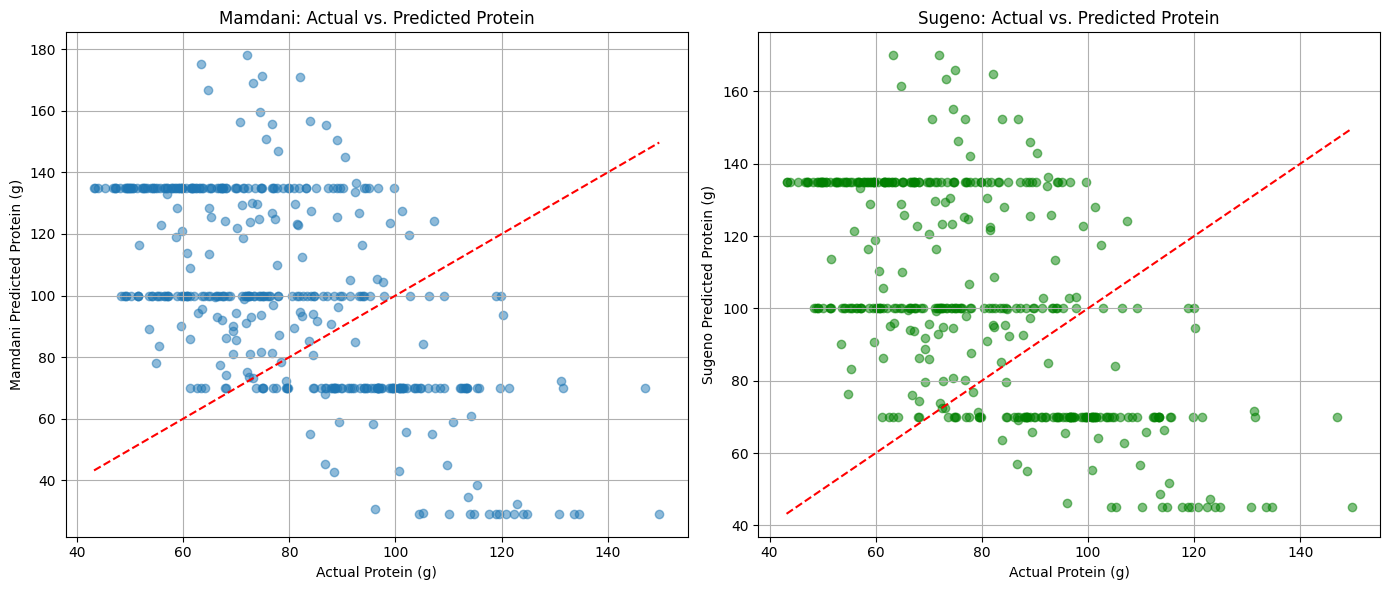

In [183]:
# Bin actual, Mamdani, and Sugeno predictions
# Handle cases where bins might be empty or cause issues with pd.cut if data is sparse
try:
    protein_actual_binned = pd.cut(bmi_df['Protein'], bins=protein_bins_edges, labels=False, include_lowest=True, duplicates='drop')
    mamdani_predicted_binned = pd.cut(bmi_df['Protein_Mamdani_Predicted'], bins=protein_bins_edges, labels=False, include_lowest=True, duplicates='drop')
    sugeno_predicted_binned = pd.cut(bmi_df['Protein_Sugeno_Predicted'], bins=protein_bins_edges, labels=False, include_lowest=True, duplicates='drop')

    # Ensure there are predicted classes before calculating F1 score
    if len(np.unique(protein_actual_binned.dropna())) > 1 and \
       len(np.unique(mamdani_predicted_binned.dropna())) > 0 and \
       len(np.unique(sugeno_predicted_binned.dropna())) > 0:

        f1_mamdani = f1_score(protein_actual_binned.dropna(), mamdani_predicted_binned.dropna(), average='macro', zero_division=0)
        f1_sugeno = f1_score(protein_actual_binned.dropna(), sugeno_predicted_binned.dropna(), average='macro', zero_division=0)
        
        print(f"\nF1 Score (Mamdani - Adjusted): {f1_mamdani:.4f}")
        print(f"F1 Score (Sugeno - Adjusted): {f1_sugeno:.4f}")
    else:
        print("\nCould not calculate F1 scores due to insufficient class diversity after binning.")

except ValueError as e:
    print(f"\nError during binning for F1 score: {e}")
    print("This might be due to all values falling into one bin or outside the specified bin ranges.")


print("\n--- Sample of Actual vs Predicted Protein ---")
print(bmi_df[['Protein', 'Protein_Mamdani_Predicted', 'Protein_Sugeno_Predicted']].head())

# Optional: Plot actual vs predicted for a visual check
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(bmi_df['Protein'], bmi_df['Protein_Mamdani_Predicted'], alpha=0.5)
plt.plot([min(bmi_df['Protein']), max(bmi_df['Protein'])], [min(bmi_df['Protein']), max(bmi_df['Protein'])], 'r--')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Mamdani Predicted Protein (g)')
plt.title('Mamdani: Actual vs. Predicted Protein')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(bmi_df['Protein'], bmi_df['Protein_Sugeno_Predicted'], alpha=0.5, color='green')
plt.plot([min(bmi_df['Protein']), max(bmi_df['Protein'])], [min(bmi_df['Protein']), max(bmi_df['Protein'])], 'r--')
plt.xlabel('Actual Protein (g)')
plt.ylabel('Sugeno Predicted Protein (g)')
plt.title('Sugeno: Actual vs. Predicted Protein')
plt.grid(True)

plt.tight_layout()
plt.show()